In [1]:
import jax.numpy as jnp
import jax
import numpy as np


Setup to load in checkpoint

In [2]:
import os.path
from experiments.plotting import load_checkpoint_w_batch_stats, load_checkpoint_wo_batch_stats

N = 100

def get_score(time=1):
    checkpoint_path = os.path.abspath(f"../../../checkpoints/ou/times/fixed_y_1_T_{time}")
    # checkpoint_path = os.path.abspath(f"../../../checkpoints/ou/1/dim_1_T_{time}")

    trained_score, restored = load_checkpoint_w_batch_stats(checkpoint_path)
    return trained_score, restored

def get_score_dims(d):
    # checkpoint_path = os.path.abspath(f"../../../checkpoints/ou/dims/fixed_y_1_d_{d}")
    checkpoint_path = os.path.abspath(f"../../../checkpoints/ou/1/dim_{d}_T_1.0")

    trained_score, restored = load_checkpoint_w_batch_stats(checkpoint_path)
    return trained_score, restored


Find errors for different d and T

In [3]:
def error(ts, true_score, trained_score, sde, x0):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(0, None, None, None))(ts, x0, sde["T"], sde["y"])
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, x0)
    return jnp.mean((true - trained) ** 2)

def error_forward(ts, true_score, trained_score, sde, y):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(None, None, 0, None))(0, sde["x0"], ts, y)
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, y)
    return jnp.mean((true - trained) ** 2)

In [4]:
_, restored = get_score(1)
print(restored["network"])
print(restored["training"])
print(restored["sde"])

{'activation': 'leaky_relu', 'batch_norm': False, 'decoder_layer_dims': [128, 128], 'encoder_layer_dims': [16], 'init_embedding_dim': 16, 'output_dim': 1, 'time_embedding_dim': 32}
{'batch_size': 100, 'epochs_per_load': 1, 'load_size': 1000, 'lr': 0.01, 'num_reloads': 100}
{'N': 100, 'T': array(1, dtype=int32), 'dim': 1, 'y': array([1.], dtype=float32)}


In [12]:
from src.sdes import sde_ornstein_uhlenbeck, time
errors = []
times = np.arange(1, 17)
true_score = sde_ornstein_uhlenbeck.score
for T in times:
    ts = time.grid(0, T, 100)
    trained_score_, restored = get_score(T)
    sde_ = restored["sde"]
    error_d_ = error(ts[:-1], true_score, trained_score_, sde_, sde_["y"])
    errors.append(error_d_)
np.save("ou_errors_reverse_times_1_to_16.npy", errors)

forward_errors = []
ds = np.arange(1, 17)
ts = time.grid(0, 1., 100)
for d in ds:
    trained_score_, restored = get_score_dims(d)
    sde_ = restored["sde"]
    error_d_ = error(ts[:-1], true_score, trained_score_, sde_, sde_["y"])
    forward_errors.append(error_d_)
np.save("ou_errors_reverse_dim_1_to_16.npy", forward_errors)

Error for T=1: 0.07658929377794266
Error for T=2: 0.01592535711824894
Error for T=3: 0.009281196631491184
Error for T=4: 0.018465371802449226
Error for T=5: 0.039476267993450165
Error for T=6: 0.028070563450455666
Error for T=7: 0.031579434871673584
Error for T=8: 0.05813705176115036
Error for T=9: 0.23409712314605713
Error for T=10: 0.2661789655685425
Error for T=11: 0.1676660180091858
Error for T=12: 0.0930444747209549
Error for T=13: 0.04620394855737686
Error for T=14: 0.03787989169359207
Error for T=15: 0.04040781781077385
Error for T=16: 0.03283161669969559
Error for d=1: 0.07658929377794266
Error for d=2: 0.02714884653687477
Error for d=3: 0.04169312119483948
Error for d=4: 0.13116970658302307
Error for d=5: 0.05124256759881973
Error for d=6: 0.11005113273859024
Error for d=7: 0.06762397289276123
Error for d=8: 0.1051810011267662
Error for d=9: 0.10558116436004639
Error for d=10: 0.5716361999511719
Error for d=11: 0.4418051838874817
Error for d=12: 0.3839656412601471
Error for d=

In [6]:
from tueplots import bundles, axes, cycler
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
axes.lines()
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))




Error plots for different d

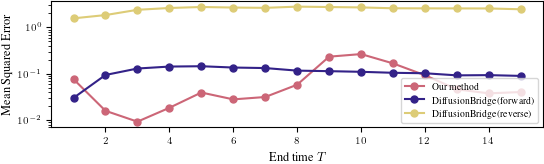

In [15]:

times = np.arange(1, 16)

errors = np.load("ou_errors_reverse_times_1_to_16.npy")    

errors_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/ornstein_uhlenbeck/diffusion_bridge_errors_forward_times_1_to_15.npy")

errors_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/ornstein_uhlenbeck/diffusion_bridge_errors_backward_times_1_to_15.npy")

plt.semilogy(times, errors[:-1], "o-", label="Our method", markersize=5)
plt.semilogy(times, errors_diffusion_bridge, "o-", label="DiffusionBridge (forward)", markersize=5)
plt.semilogy(times, errors_diffusion_bridge_reverse, "o-", label="DiffusionBridge (reverse)", markersize=5)
# plt.semilogx(ds, forward_errors, "o-", label="Forward")
plt.legend()
# plt.xticks(ds, ds)
plt.xlabel(r"End time $T$")
plt.ylabel("Mean Squared Error")
# plt.ylim((-1, 5))
plt.savefig("time_comparison.pdf")
plt.show()


In [8]:
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
axes.lines()
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))



Create Subplots for both time and dimension

In [16]:
times = np.arange(1, 16)

errors_t = np.load("ou_errors_reverse_times_1_to_16.npy")    
errors_t_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/ornstein_uhlenbeck/diffusion_bridge_errors_forward_times_1_to_15.npy")
errors_t_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/ornstein_uhlenbeck/diffusion_bridge_errors_backward_times_1_to_15.npy")


In [17]:

from src.sdes import sde_ornstein_uhlenbeck, time

ds = np.arange(1, 33)
ts = time.grid(0, 1., 100)

errors_d = np.load("ou_errors_reverse_dim_1_to_16.npy") 

errors_d_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/dims/diffusion_bridge_errors_forward_dims_1_to_32.npy")
errors_d_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/dims/diffusion_bridge_errors_backward_dims_1_to_16.npy")


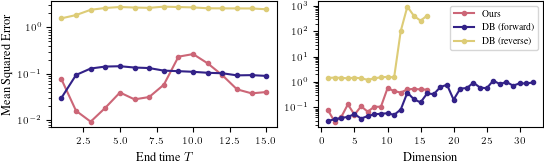

In [19]:
plt.rcParams.update(figsizes.neurips2023(nrows=1, ncols=2))
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False)

axs[0].semilogy(times, errors_t[:-1], "o-", label="Ours", markersize=3)
axs[0].semilogy(times, errors_t_diffusion_bridge, "o-", label="DB (forward)", markersize=3)
axs[0].semilogy(times, errors_t_diffusion_bridge_reverse, "o-", label="DB (reverse)", markersize=3)
axs[0].set_xlabel(r"End time $T$")
axs[0].set_ylabel("Mean Squared Error")

axs[1].semilogy(ds[:16], errors_d, "o-", label="Ours", markersize=3)
axs[1].semilogy(ds, errors_d_diffusion_bridge, "o-", label="DB (forward)", markersize=3)
axs[1].semilogy(ds[:16], errors_d_diffusion_bridge_reverse, "o-", label="DB (reverse)", markersize=3)
axs[1].set_xlabel("Dimension")
axs[1].legend()

plt.savefig("time_and_dims_errors.pdf")
